# Assignment 3: Clustering California Housing with K-means

### CS 6316 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you (for free) from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [1]:
# Common imports
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
import sys

In [2]:
# You might want to use the following package
from operator import sub
from copy import deepcopy
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from future_encoders import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from future_encoders import ColumnTransformer
from scipy.spatial import distance
from scipy import stats

In [3]:
# to make this notebook's output stable across runs
np.random.seed(42)

##### Data Acquisition

In [4]:
# setting up file and extracting data from csv
housing = pd.read_csv("housing.csv")

##### Data Discovery & Visualization

In [5]:
# housing.head()
# housing.info()
# housing.describe()

In [6]:
corr_matrix = housing.corr()
# corr_matrix["median_house_value"].sort_values(ascending=False)

In [5]:
# import matplotlib.image as mpimg
# california_img=mpimg.imread("." + '/images/end_to_end_project/california.png')
# ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
#                        s=housing['population']/100, label="Population",
#                        c="median_house_value", cmap=plt.get_cmap("jet"),
#                        colorbar=False, alpha=0.4,
#                       )
# plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
#            cmap=plt.get_cmap("jet"))
# plt.ylabel("Latitude", fontsize=14)
# plt.xlabel("Longitude", fontsize=14)

# prices = housing["median_house_value"]
# tick_values = np.linspace(prices.min(), prices.max(), 11)
# cbar = plt.colorbar()
# cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
# cbar.set_label('Median House Value', fontsize=16)

# plt.legend(fontsize=16)
# plt.show()

##### Data Cleaning & Preparation

In [5]:
housing_c = housing.copy()

In [6]:
housing_num = housing.drop('ocean_proximity', axis=1)
num_attribs = list(housing_num)

cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [7]:
housing_prepared = full_pipeline.fit_transform(housing)

In [8]:
data = housing_prepared;

- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster, and it can be represented just like a normal cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure**.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in gene assignment occurs between iterations.

**Distance Measures:** Your implementation must have an option of using two distance measures for clustering: 
- Euclidean distance: Euclidean distance measures differences in the absolute levels of instances.
$d(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}2]{\sum\limits_{i=1}^n|x_i - y_i|^2}$
- Pearson rank correlation: Pearson rank correlation uses ranks in place of absolute values, which makes it less sensitive to outliers (extremely high or low values) in the data.
$d(\mathbf{x},\mathbf{y}) = \frac{\sum_i (x^{(i)} - \bar{x})(y^{(i)} - \bar{y})}{\sqrt{\sum_i (x^{(i)} - \bar{x})^2 \sum_i (y^{(i)} - \bar{y})^2}}$

**Implementation Notes:** Note that these functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical. This requirement is already met for Euclidean distance, but Pearson rank correlation varies between -1 and 1, and high values indicate similarity. Therefore, you must transform the Pearson rank correlation so that the returned value is always greater than or equal to zero, with high values indicating dissimilarity.

In [9]:
def kmeans(dataSet, k, choice):
    num = data.shape[0] # training data number
    feat = data.shape[1] # number of features

    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    centroids = getCentroids(data, k)*std + mean

    centers_old = np.zeros(centroids.shape) # to store old centers
    centers_new = deepcopy(centroids) # Store new centers

    if (choice.lower() == 'euclid'):
        error = euclideanDist(centers_new, centers_old, None)
    else: 
        error = pearsonDist(centers_new, centers_old)

    while error != 0:
        labels = getLabels(data, centroids, k)
        clusters = labels[1]
        centers_new = updateCentroids(data, labels[0], k, centers_new, centers_old)
        if (choice.lower() == 'euclid'):
            error = euclideanDist(centers_new, centers_old, None)
        else:
            error = pearsonDist(centers_new, centers_old)
    centroids = centers_new
    
    return [centroids,labels, clusters]

In [10]:
# Returns a label for each piece of data in the dataset. 
def getLabels(dataSet, centroids, k):
    n = dataSet.shape[0]
    clusters = np.zeros(n)
    distances = np.zeros((n,k))
    for i in range(k):
          distances[:,i] = euclideanDist(dataSet, centroids[i], 1)
    clusters = np.argmin(distances, axis = 1)
    return [clusters, distances]

In [11]:
# Returns k random centroids, each of dimension n.
def getCentroids(dataSet, k):
    centroids = []
    n = dataSet.shape[1] # num of feature
    for i in range(k):
        val = np.random.randn(k, n)
    centroids.append(val)
    centroids = np.array(centroids).reshape((k,n))
    return centroids

In [12]:
# Returns the new value of centroid as the average of it cluster.
def updateCentroids(dataSet, clusters, k, old, new):
    old = deepcopy(new)
    for i in range(k):
        new[i] = np.mean(dataSet[clusters == i], axis=0)
    return new

In [13]:
# Simple implementation of Euclidean distance equation.
def euclideanDist(x, y, a):
    dist = np.linalg.norm(x - y, axis=a)
    return dist

In [14]:
# Converts the correlation coefficient with values between -1 and 1 to a score between 0 and 1.
def pearsonDist(a, b):
    x = (a - np.mean(a))
    y = (b - np.mean(b))
    S_x = np.sum(x**2)
    S_y = np.sum(y**2)
    S_xy = np.sum(x*y)
    num = S_xy
    den = math.sqrt(S_x * S_y)
    r = num/den
    d = (1 - r)/2
    return d

- - -
## 3. CLUSTERING HOUSING INTO REGIONS (30 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for 2 clusters to see if you can split California into a Northern and Southern regions.

**Cluster the data:** Write down the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

**Change the number of clusters:** Change K from 2 to 10 and repeat the clustering process above. Record cluster means and standard deviations. When you change K, do any additional patterns emerge? If so, what are they?
Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.

In [15]:
def clusterSSE(cluster,k):
    sum = 0
    means = clusterMean(cluster, k)
    for x in cluster:
        for i in range(k):
            w = (x[i] - means[i])**2
            sum += w
    return sum

In [16]:
def clusterMean(cluster,k):
    means = np.zeros(clusters.shape[1])
    for x in clusters:
        for i in range(k):
            means[i] += np.mean(clusters[i])/(cluster.shape[0])
    return means

In [17]:
def clusterSTD(cluster,k):
    stds = np.zeros(clusters.shape[1])
    for x in clusters:
        for i in range(k):
            stds[i] += np.std(clusters[i])/(cluster.shape[0])
    return stds

In [75]:
sse_ = []

In [76]:
k = 2
choice = 'euclid'
my_kmeans = kmeans(data, k, choice)
center = my_kmeans[0]
labels = my_kmeans[1]
clusters = my_kmeans[2]

In [77]:
# Cluster SSE, Mean, STD
sse = clusterSSE(clusters, k)
mean = clusterMean(clusters, k)
std = clusterSTD(clusters, k)
print(sse)
print(mean)
print(std)
sse_.append(sse)

265520.50059634156
[5.18084105 5.87464632]
[0.23300117 0.07988522]


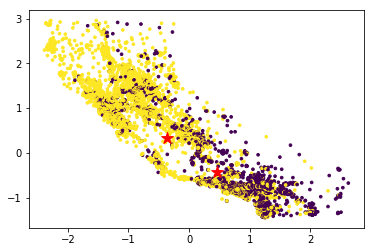

In [29]:
long = data[:,0]
lat = data[:,1]
plt.scatter(long, lat, c= labels[0], s=7)
plt.scatter(center[:,0], center[:,1], marker='*', c='r', s=150)

In [78]:
k = 3
choice = 'euclid'
my_kmeans = kmeans(data, k, choice)
center = my_kmeans[0]
labels = my_kmeans[1]
clusters = my_kmeans[2]

In [79]:
# Cluster SSE, Mean, STD
sse = clusterSSE(clusters, k)
mean = clusterMean(clusters, k)
std = clusterSTD(clusters, k)
print(sse)
print(mean)
print(std)
sse_.append(sse)

160648.8659812795
[5.16120008 5.1437267  4.65992923]
[0.8188039  0.34485484 0.80745521]


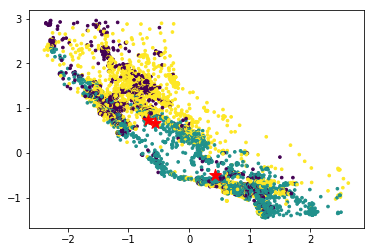

In [32]:
long = data[:,0]
lat = data[:,1]
plt.scatter(long, lat, c= labels[0], s=7)
plt.scatter(center[:,0], center[:,1], marker='*', c='r', s=150)

In [80]:
k = 4
choice = 'euclid'
my_kmeans = kmeans(data, k, choice)
center = my_kmeans[0]
labels = my_kmeans[1]
clusters = my_kmeans[2]

In [81]:
# Cluster SSE, Mean, STD
sse = clusterSSE(clusters, k)
mean = clusterMean(clusters, k)
std = clusterSTD(clusters, k)
print(sse)
print(mean)
print(std)
sse_.append(sse)

299030.2773169018
[5.6697693  5.91936363 5.38311951 5.01277072]
[0.68121942 0.84542864 0.62824556 0.68289529]


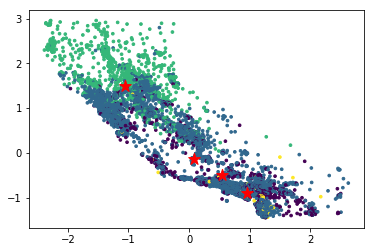

In [35]:
long = data[:,0]
lat = data[:,1]
plt.scatter(long, lat, c= labels[0], s=7)
plt.scatter(center[:,0], center[:,1], marker='*', c='r', s=150)

In [82]:
k = 5
choice = 'euclid'
my_kmeans = kmeans(data, k, choice)
center = my_kmeans[0]
labels = my_kmeans[1]
clusters = my_kmeans[2]

In [83]:
# Cluster SSE, Mean, STD
sse = clusterSSE(clusters, k)
mean = clusterMean(clusters, k)
std = clusterSTD(clusters, k)
print(sse)
print(mean)
print(std)
sse_.append(sse)

264225.25081776094
[5.21766174 5.12273147 4.78807441 4.4898811  4.29227722]
[0.97814758 0.47226929 0.9853871  0.82481075 0.5993178 ]


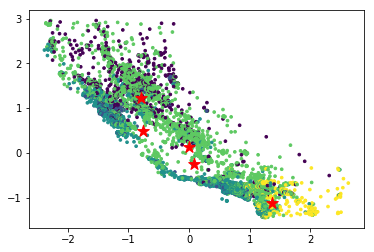

In [38]:
long = data[:,0]
lat = data[:,1]
plt.scatter(long, lat, c= labels[0], s=7)
plt.scatter(center[:,0], center[:,1], marker='*', c='r', s=150)

In [94]:
k = 6
chioce = 'pearson'
my_kmeans = kmeans(data, k, choice)
center = my_kmeans[0]
labels = my_kmeans[1]
clusters = my_kmeans[2]

In [95]:
# Cluster SSE, Mean, STD
sse = clusterSSE(clusters, k)
mean = clusterMean(clusters, k)
std = clusterSTD(clusters, k)
#389158.7145515846
print(sse)
print(mean)
print(std)
# sse_.append(sse)

294632.3501858873
[5.36102865 5.38750264 4.79735964 4.44076942 4.21395308 4.21141118]
[1.01429869 0.76345248 0.97323133 0.91270623 0.84217985 0.78205126]


In [96]:
sse_.append(sse)

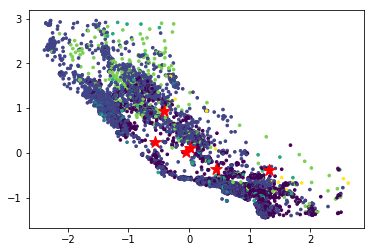

In [54]:
long = data[:,0]
lat = data[:,1]
plt.scatter(long, lat, c= labels[0], s=7)
plt.scatter(center[:,0], center[:,1], marker='*', c='r', s=150)

In [98]:
k = 7
chioce = 'pearson'
my_kmeans = kmeans(data, k, choice)
center = my_kmeans[0]
labels = my_kmeans[1]
clusters = my_kmeans[2]

In [99]:
# Cluster SSE, Mean, STD
sse = clusterSSE(clusters, k)
mean = clusterMean(clusters, k)
std = clusterSTD(clusters, k)
print(sse)
print(mean)
print(std)

306427.1366219637
[5.20583123 5.57426478 4.79999741 4.4514162  4.25466375 4.23262091
 4.01869226]
[0.65566581 0.56762696 0.69334558 0.70392618 0.74246334 0.73089537
 0.70624234]


In [101]:
sse_.append(sse)

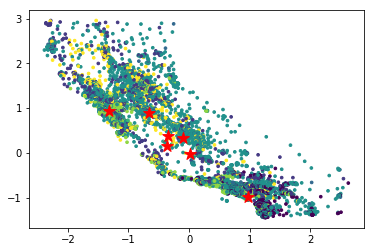

In [57]:
long = data[:,0]
lat = data[:,1]
plt.scatter(long, lat, c= labels[0], s=7)
plt.scatter(center[:,0], center[:,1], marker='*', c='r', s=150)

In [102]:
k = 8
chioce = 'pearson'
my_kmeans = kmeans(data, k, choice)
center = my_kmeans[0]
labels = my_kmeans[1]
clusters = my_kmeans[2]

In [103]:
# Cluster SSE, Mean, STD
sse = clusterSSE(clusters, k)
mean = clusterMean(clusters, k)
std = clusterSTD(clusters, k)
print(sse)
print(mean)
print(std)

333536.6112617411
[5.52716674 5.26639467 5.16599021 4.9054594  4.76977501 4.8216707
 4.44156167 4.3709223 ]
[1.07436144 0.92131912 1.06455802 1.0672694  1.07855813 1.03074057
 1.02454399 0.92877344]


In [104]:
sse_.append(sse)

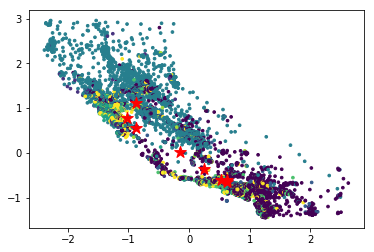

In [60]:
long = data[:,0]
lat = data[:,1]
plt.scatter(long, lat, c= labels[0], s=7)
plt.scatter(center[:,0], center[:,1], marker='*', c='r', s=150)

In [105]:
k = 9
chioce = 'pearson'
my_kmeans = kmeans(data, k, choice)
center = my_kmeans[0]
labels = my_kmeans[1]
clusters = my_kmeans[2]

In [106]:
# Cluster SSE, Mean, STD
sse = clusterSSE(clusters, k)
mean = clusterMean(clusters, k)
std = clusterSTD(clusters, k)
print(sse)
print(mean)
print(std)

399779.21296238696
[4.57705427 5.20985805 4.26912847 3.96429857 3.81712103 3.86315116
 3.7110315  3.8043184  3.56789277]
[0.76220583 1.23996406 0.63461154 0.63806079 0.68583936 0.69267282
 0.64777237 0.72223401 0.67868625]


In [107]:
sse_.append(sse)

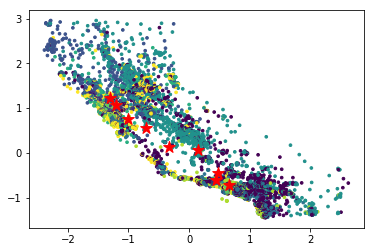

In [63]:
long = data[:,0]
lat = data[:,1]
plt.scatter(long, lat, c= labels[0], s=7)
plt.scatter(center[:,0], center[:,1], marker='*', c='r', s=150)

In [109]:
k = 10
chioce = 'pearson'
my_kmeans = kmeans(data, k, choice)
center = my_kmeans[0]
labels = my_kmeans[1]
clusters = my_kmeans[2]

In [110]:
# Cluster SSE, Mean, STD
sse = clusterSSE(clusters, k)
mean = clusterMean(clusters, k)
std = clusterSTD(clusters, k)
print(sse)
print(mean)
print(std)

556164.5796424504
[5.58106597 5.39984611 5.28299653 4.94335766 4.73675434 4.76563897
 4.43262385 4.33353745 3.99761716 4.37001625]
[0.69889586 0.75835271 0.54109718 0.54363588 0.5593956  0.54046728
 0.45427051 0.50793713 0.39990832 0.56535332]


In [111]:
sse_.append(sse)

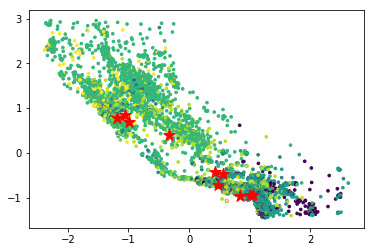

In [66]:
long = data[:,0]
lat = data[:,1]
plt.scatter(long, lat, c= labels[0], s=7)
plt.scatter(center[:,0], center[:,1], marker='*', c='r', s=150)

In [112]:
print(sse_)

[265520.50059634156, 160648.8659812795, 299030.2773169018, 264225.25081776094, 294632.3501858873, 306427.1366219637, 306427.1366219637, 333536.6112617411, 399779.21296238696, 556164.5796424504]


In [113]:
import operator
sse_ = sorted(sse_,reverse=True)

Text(0.5,1,'SSE vs K')

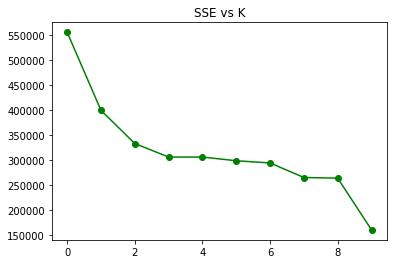

In [120]:
plt.plot(sse_, 'go-')
plt.title('SSE vs K')

Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? When you change K, do any additional patterns emerge? If so, what are they? 

**Response:** The clusters that were found seem to be a good representation of the most populated regions of California, or the largest cities of California (and possibly the areas that have the highest incidences of homelessness) namely San Francisco and Los Angeles. The gaps for clusters can be attributed to areas with lesser population density (possibly due to geographic reasons: mountains/desert etc.) The mean values for each attribute appear to be pretty consistent no matter the value for  k, additionally, lower values of k seem to provide smaller standard deviations (note standard deviations were scaled in order to more clearly see their values).

- - -
## 4. WRITE ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (20 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting). Additionally, did you have any insight on which similarity measure (either Euclidean or Pearson Correlation) work better in this dataset.

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



**Response:** For this data set, having more clusters gave a more distinctive view of the regions in California that appeared to have the highest population density: Silicon Valley, San Francisco, and Los Angeles. After running several iterations of kmeans, I observed that the Pearson Correlation which was scaled and weighted to become the Pearson Distance performed better with cluster numbers greater than 6 (data with more dimensions), whereas Euclidean performed better results for cluster numbers that were 5 or smaller. 
Ways I think the California Housing Crisis could be improved by providing homeless people with more opportunities to find housing; specifically, the prompt says that housing prices in California's larger cities are on the rise, so why not make housing more accessible? Building more affordable housing for low income residents would be the best alternative, but if this isnt feasible, providing them with a means of obtaining home loans for this region would be extremely helpful. Additionally, a thoughtful way to help disabled homeless people obtain housing could be to use existing mental health/ disabilites funds to build supportive housing for people who are members of these communities.


- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](https://docs.google.com/document/d/15qB84xjaS-uRJmfKmmQuCz38bLMFaoqdbuRLoZEdOYI/edit#heading=h.72k1pvft525n)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS6316 Assignment 3:...".

Best of luck and have fun!